In [1]:
import ROOT
import os
import json
import uproot
import pandas as pd
import yaml
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import catboost
from catboost import CatBoostClassifier

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-aqgox_pp because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [35]:
pltfmt={
    "g1R": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "g1R"},
    "g2R": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "g2R"},
    "h1R": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "h1R"},
    "h2R": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "h2R"},
    "g_pcal_e": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "E_{PCAL}(\gamma)"},
    "gE": {"min": 0, "max": 5, "bins": 50, "xtitle": "E(\gamma)"},
    "g_pcal_m2u": {"min": 0, "max": 50, "bins": 50, "xtitle": "m2u_{PCAL}(\gamma)"},
    "g_pcal_m2v": {"min": 0, "max": 50, "bins": 50, "xtitle": "m2v_{PCAL}(\gamma)"},
    "g1_pcal_e": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "E_{PCAL}(g1)"},
    "g2_pcal_e": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "E_{PCAL}(g2)"},
    "h1dE": {"min": -4, "max": 1, "bins": 50, "xtitle": "h1dE [GeV]"},
    "h2dE": {"min": -4, "max": 1, "bins": 50, "xtitle": "h2dE [GeV]"},
    "gTheta": {"min": 0, "max": 0.6, "bins": 50, "xtitle": "\Theta(\gamma)"},
    "eR": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "eR"},
    "edE": {"min": 0, "max": 1.2, "bins": 50, "xtitle": "edE [GeV]"},
    "nPhotons": {"min": 0, "max": 10, "bins": 10, "xtitle": "nPhotons"},
    "nHadrons": {"min": 0, "max": 10, "bins": 10, "xtitle": "nHadrons"}
}

In [16]:
# open the file
JSON_NAME="/work/clas12/users/gmat/nnPi0/catboost/utils/subdata.json"
with open(JSON_NAME) as json_file:
    # load the json data
    JSON = json.load(json_file)

In [26]:
# Given a filename, determine the run number
def extract(string):
    if "MC" in string:
        start = string.find("MC_") + 3
        end = string.find(".root")
        return string[start:end]
    else:
        start = string.find("nSidis_") + 7
        end = string.find(".root")
        return string[start:end]

# Get files corresponding to the header in the JSON
def get_files(input_dir="",header=""):
    
    files=[]
    for file in os.listdir(input_dir):
        run = extract(file)
        if(run in JSON[header]):
            files.append(input_dir+"/"+file)
        if(len(files)==5):
            break
    return files

# Create pandas df 
def make_panda(input_dir="", version="",maxFiles=999,inputs=[]):
    files = get_files(input_dir,version)
    if(len(files)>maxFiles):
        files=files[:maxFiles]
    trees = [uproot.open(file)["PreProcessedEvents"] for file in files]
    dfs = [tree.arrays(library="pd") for tree in trees]
    output_df = pd.concat(dfs)
    cols = list(output_df.columns) 
    
    usecols = [c for c in cols if not c in inputs+['flag']]
    output_df=output_df.drop(usecols,axis=1)
    output_df=output_df[inputs+['flag']] # Reorder
    return output_df

# Create multiple pandas df's
def make_pandas(input_dir="",maxFiles=999,inputs=[]):
    df_data_f18_inbending = make_panda(input_dir,"Fall2018_inbending",maxFiles,inputs)
    df_data_f18_outbending = make_panda(input_dir,"Fall2018_outbending",maxFiles,inputs)
    df_data_s19_inbending = make_panda(input_dir,"Spring2019_inbending",maxFiles,inputs)
    df_MC_inbending = make_panda(input_dir,"MC_inbending",maxFiles,inputs)
    df_MC_outbending = make_panda(input_dir,"MC_outbending",maxFiles,inputs)
    return df_data_f18_inbending, df_data_f18_outbending, df_data_s19_inbending, df_MC_inbending, df_MC_outbending


# Get directories for analysis
def get_dirs(PROJECT_NAME,MLmethod):
    pathtowork="/work/clas12/users/gmat/scipio/projects"
    pathtovolatile="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects"
    input_dir = f"{pathtovolatile}/{PROJECT_NAME}/{MLmethod}/MLinput"
    inbending_model_dir = f"{pathtowork}/{PROJECT_NAME}/{MLmethod}/model_inbending"
    outbending_model_dir = f"{pathtowork}/{PROJECT_NAME}/{MLmethod}/model_outbending"
    yaml_inputs = f"{pathtowork}/{PROJECT_NAME}/{MLmethod}/MLinputs.yaml"
    outdir = f"{pathtowork}/{PROJECT_NAME}/{MLmethod}"
    return input_dir,inbending_model_dir,outbending_model_dir, yaml_inputs,outdir

# Get input branches for the ML
def get_ML_inputs(yaml_inputs):
    with open(yaml_inputs,'r') as file:
        inyaml = yaml.safe_load(file)

    BRANCH_NAMES = inyaml["inputs"]
    return BRANCH_NAMES

# Get model from the ML
def load_model(MODEL_DIR):
    from_file = CatBoostClassifier()
    from_file.load_model(MODEL_DIR+"/catboost_model")
    return from_file

# Use the loaded model to make photon predictions
def get_prob(df,model):
    return model.predict_proba(df.to_numpy()[:,:-1])[:,1]

In [27]:
PROJECT_NAME = "pipluspi0_prelim"
MLmethod="catboost"

In [19]:
input_dir, inbending_model_dir, outbending_model_dir, yaml_file,outdir = get_dirs(PROJECT_NAME,MLmethod)
model_inbending, model_outbending=load_model(inbending_model_dir),load_model(outbending_model_dir)

inputs = get_ML_inputs(yaml_file)

In [20]:
df_f18_inbending, df_f18_outbending, df_s19_inbending, df_MC_inbending, df_MC_outbending = make_pandas(input_dir,1,inputs)
prob_f18_inbending = get_prob(df_f18_inbending,model_inbending)
prob_f18_outbending = get_prob(df_f18_outbending,model_outbending)
prob_s19_inbending = get_prob(df_s19_inbending,model_inbending)
prob_MC_inbending = get_prob(df_MC_inbending,model_inbending)
prob_MC_outbending = get_prob(df_MC_outbending,model_outbending)

In [38]:
def make_model_comparison_plot(df_data,df_MC,version,outdir,inputs):
    
    outdir=outdir+"/comparison"
    if(not os.path.exists(outdir)):
        os.makedirs(outdir)
    
    # Get number of rows in grid
    n_rows = (len(inputs) // 4) + 1

    # Set up grid of subplots
    fig, ax = plt.subplots(n_rows, 4, figsize=(8, 2*n_rows),dpi=150)

    # Plot data for each input column
    for i, branch in enumerate(inputs):
        if(branch=="flag"):
            continue
        row = i // 4
        col = i % 4
        ax[row, col].hist(df_data[branch][(df_data[branch]!=0)], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, label='nSidis')
        ax[row, col].hist(df_MC[branch][(df_MC[branch]!=0)], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, label='Monte Carlo')
        xtitle="$\mathrm{"+pltfmt[branch]["xtitle"]+"}$"
        ax[row, col].set_xlabel(r"{}".format(xtitle))
        if col == 0:
            ax[row, col].legend()
        if(branch in ["g_pcal_m2u", "g_pcal_m2v"]):
            ax[row,col].set_yscale("log")
    for c in range(col+1,4):
        fig.delaxes(ax[row,c])
    # Tighten layout and show plot
    plt.tight_layout()
    plt.show()
    plt.savefig(outdir+"/"+version+"_all.png")

In [39]:
def make_model_sigbg_comparison_plot(df_data,df_MC,prob_data,prob_MC,version,outdir,inputs):
    
    outdir=outdir+"/comparison"
    if(not os.path.exists(outdir)):
        os.makedirs(outdir)
    
    # Get number of rows in grid
    n_rows = (len(inputs) // 4) + 1
    # Set up grid of subplots
    fig, ax = plt.subplots(n_rows, 4, figsize=(8, 2*n_rows),dpi=150)

    # Plot data for each input column
    for i, branch in enumerate(inputs):
        if(branch=="flag"):
            continue
        row = i // 4
        col = i % 4
        ax[row, col].hist(df_data[branch][(df_data[branch]!=0) & (prob_data>0.9)], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, color="red", label='nSidis signal')
        ax[row, col].hist(df_data[branch][(df_data[branch]!=0) & (prob_data<0.9)], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, linestyle='dashed',color="orange",label='nSidis bkg')
        ax[row, col].hist(df_MC[branch][(df_MC[branch]!=0) & (prob_MC>0.9) ], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, color="green",label='MC signal')
        ax[row, col].hist(df_MC[branch][(df_MC[branch]!=0) & (prob_MC<0.9) ], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, linestyle='dashed',color="royalblue",label='MC bkg')
        xtitle="$\mathrm{"+pltfmt[branch]["xtitle"]+"}$"
        ax[row, col].set_xlabel(r"{}".format(xtitle))
        if (col == 0 and row == 0):
            ax[row, col].legend()
        if(branch in ["g_pcal_m2u", "g_pcal_m2v"]):
            ax[row,col].set_yscale("log")
    for c in range(col+1,4):
        fig.delaxes(ax[row,c])
    # Tighten layout and show plot
    plt.tight_layout()
    plt.show()
    plt.savefig(outdir+"/"+version+"_sigbg.png")

In [40]:
def make_model_MC_comparison_plot(df_MC,prob_MC,version,outdir,inputs):
    
    outdir=outdir+"/comparison"
    if(not os.path.exists(outdir)):
        os.makedirs(outdir)
    
    # Get number of rows in grid
    n_rows = (len(inputs) // 4) + 1
    
    # Set up grid of subplots
    fig, ax = plt.subplots(n_rows, 4, figsize=(8, 2*n_rows),dpi=150)

    # Plot data for each input column
    for i, branch in enumerate(inputs):
        if(branch=="flag"):
            continue
        row = i // 4
        col = i % 4
        
        ax[row, col].hist(df_MC[branch][(df_MC[branch]!=0) & (prob_MC>0.9) ], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, color="red",label='MC sig')
        ax[row, col].hist(df_MC[branch][(df_MC[branch]!=0) & (df_MC["flag"]==1)], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, linestyle='dashed',color="orange",label='catboost sig')
        ax[row, col].hist(df_MC[branch][(df_MC[branch]!=0) & (prob_MC<0.9) ], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, color="green",label='MC bkg')
        ax[row, col].hist(df_MC[branch][(df_MC[branch]!=0) & (df_MC["flag"]==0)], bins=50, range=(pltfmt[branch]["min"],pltfmt[branch]["max"]),histtype=u'step', density=True, linestyle='dashed',color="blue",label='catboost bkg')
        xtitle="$\mathrm{"+pltfmt[branch]["xtitle"]+"}$"
        ax[row, col].set_xlabel(r"{}".format(xtitle))
        if (col == 0 and row == 0):
            ax[row, col].legend()
        if(branch in ["g_pcal_m2u", "g_pcal_m2v"]):
            ax[row,col].set_yscale("log")
    for c in range(col+1,4):
        
        fig.delaxes(ax[row,c])
    # Tighten layout and show plot
    plt.tight_layout()
    plt.show()
    plt.savefig(outdir+"/"+version+"_MC.png")

# Create Figures
---

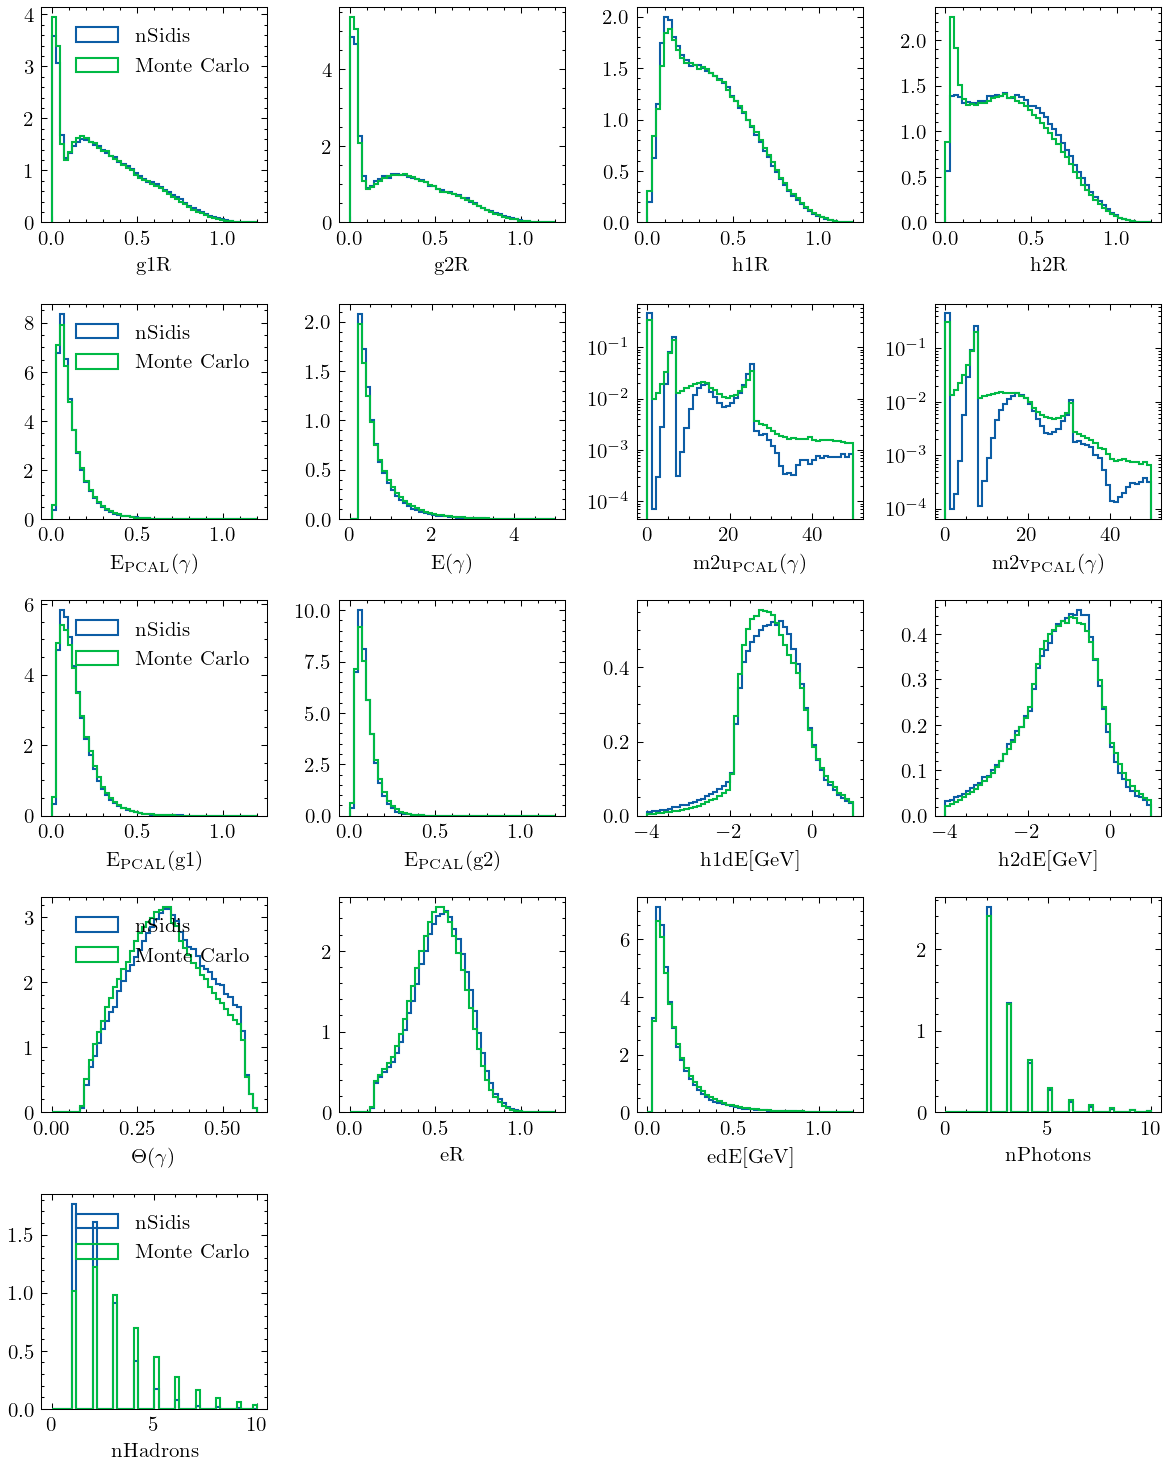

<Figure size 252x189 with 0 Axes>

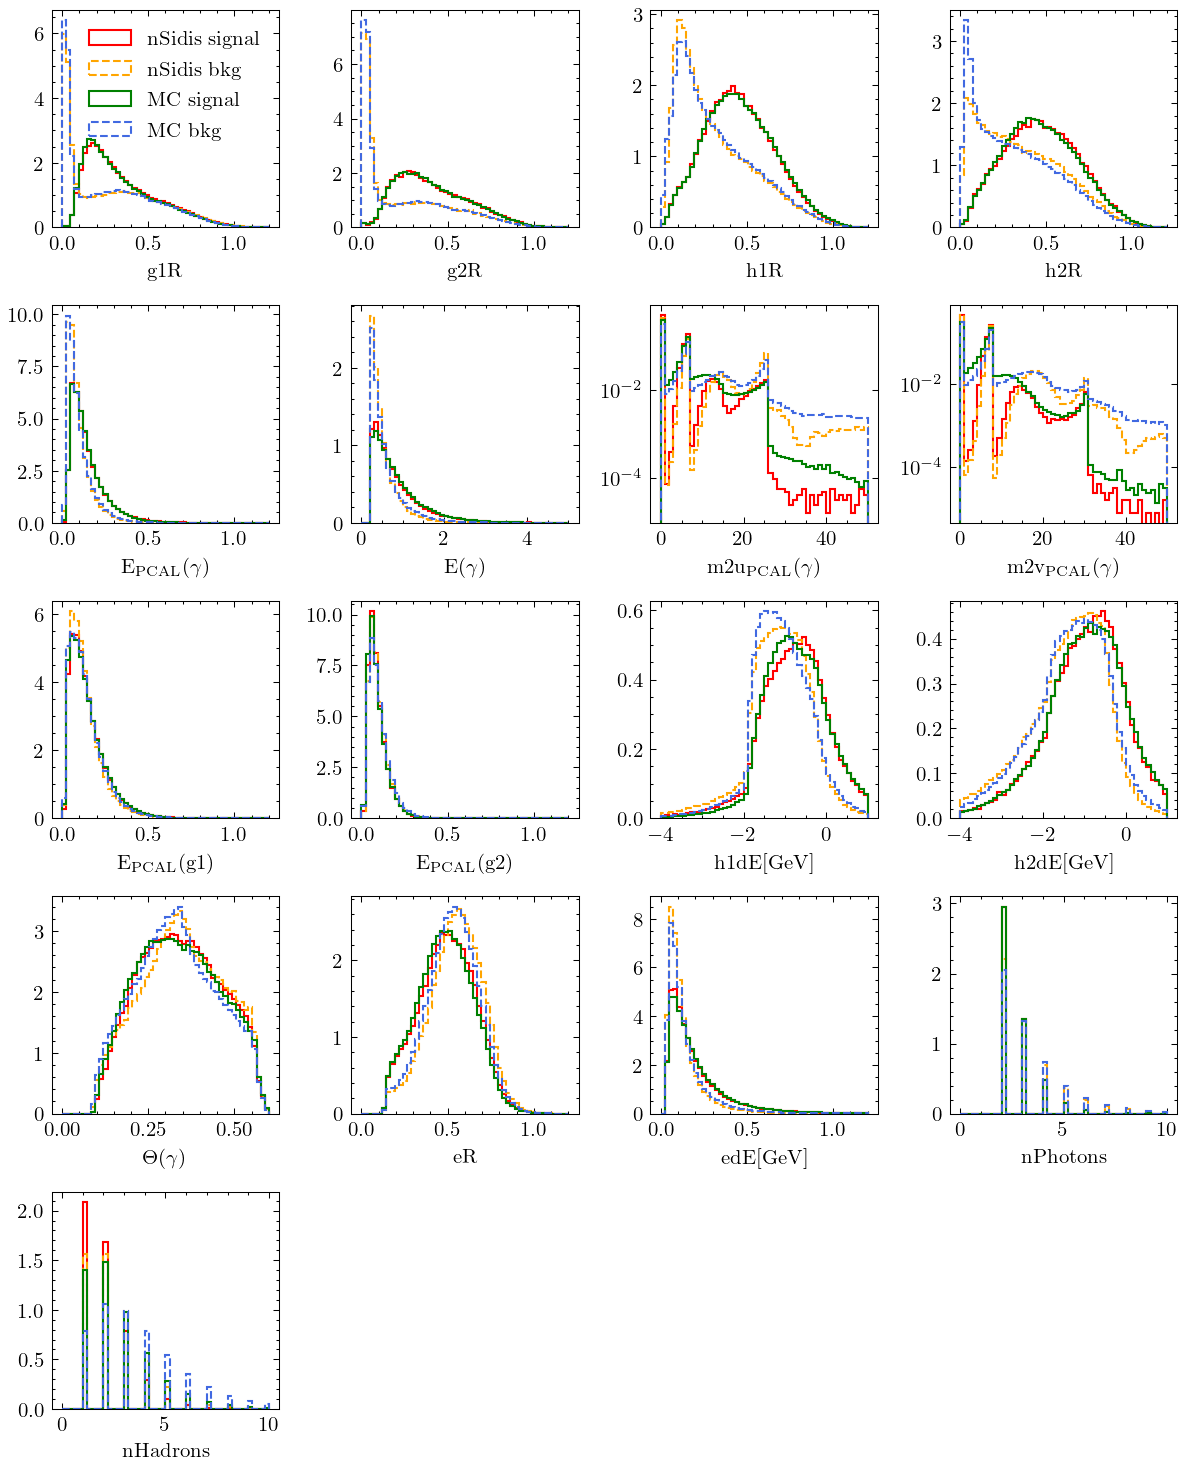

<Figure size 252x189 with 0 Axes>

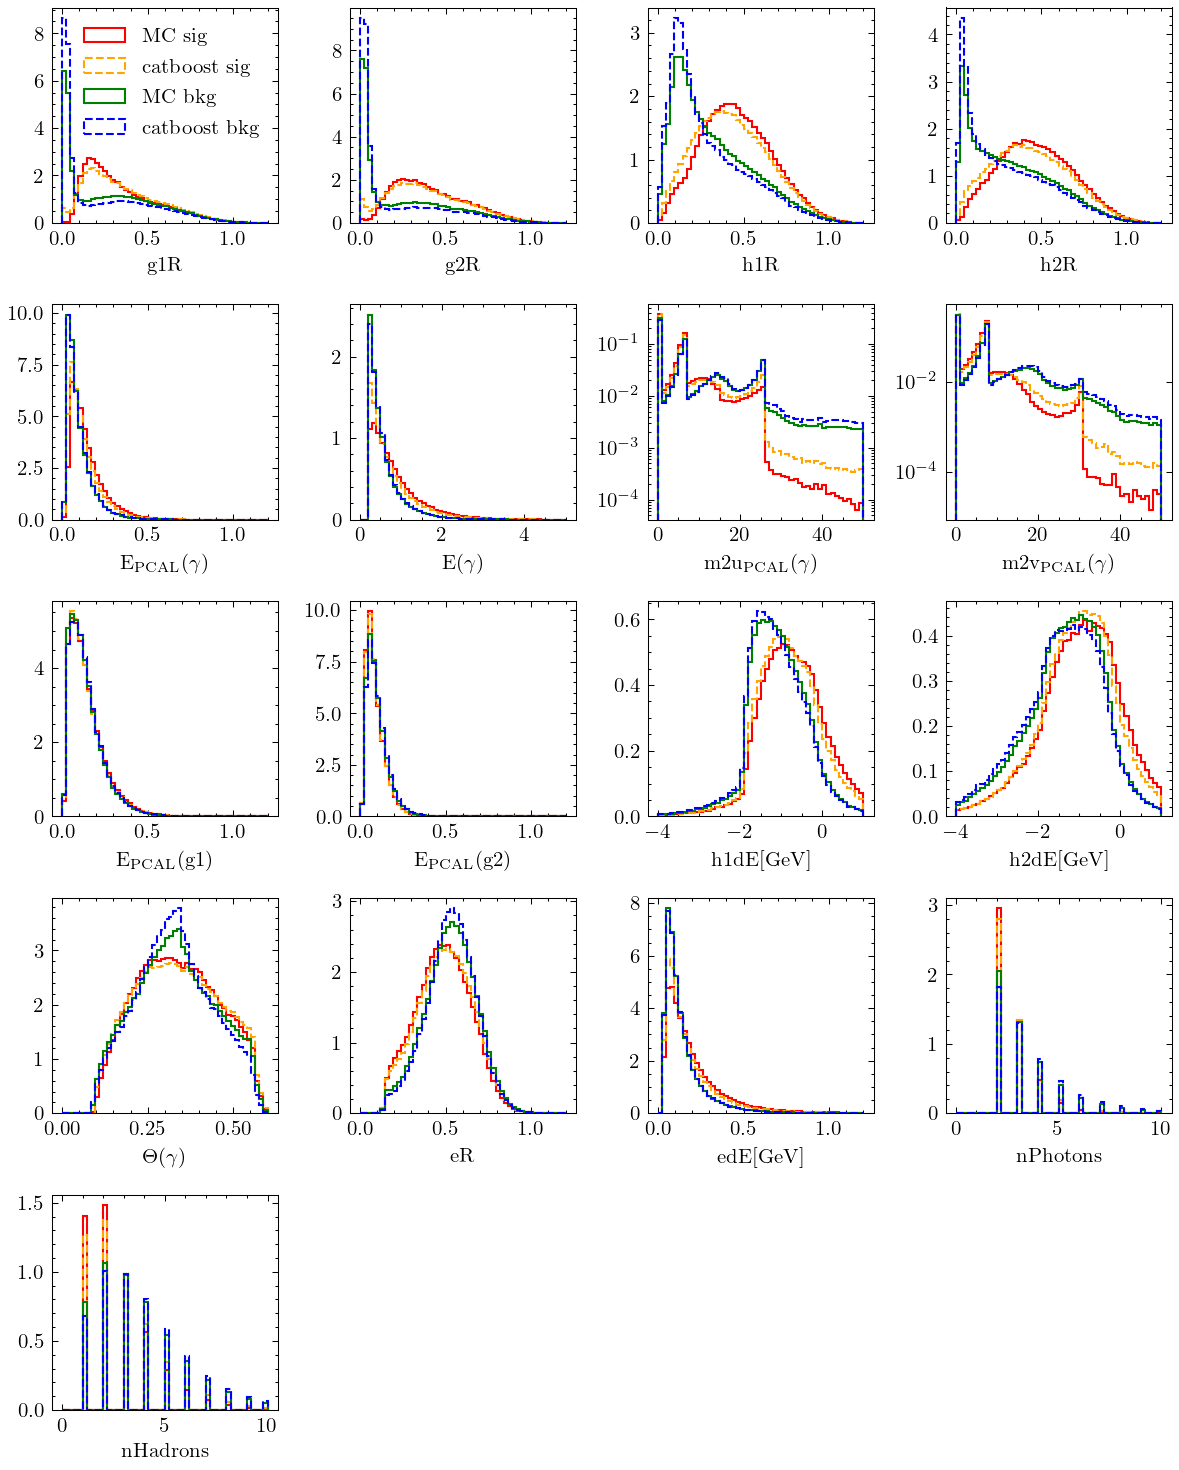

<Figure size 252x189 with 0 Axes>

In [41]:
make_model_comparison_plot(df_f18_inbending,df_MC_inbending,"Fall2018_inbending",outdir,inputs)
make_model_sigbg_comparison_plot(df_f18_inbending,df_MC_inbending,prob_f18_inbending,prob_MC_inbending,"Fall2018_inbending",outdir,inputs)
make_model_MC_comparison_plot(df_MC_inbending,prob_MC_inbending,"MC_inbending",outdir,inputs)